<img src="https://static.wixstatic.com/media/66c28f_db7a1ba3e35b4b17a6688472c889b7bf~mv2_d_2777_1254_s_2.png/v1/fill/w_710,h_320,al_c,q_85,usm_0.66_1.00_0.01/logo_yellow_white.webp" width=1000, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

# Text Summarization

Всем привет! Сегодня мы познакомимся с задачей суммаризации текста на примере генерации "сжатых" новостей. Рассмотрим некоторые базовые решения и познакомимся с архитектурами нейросетей для решения задачи.
Датасет: gazeta.ru


`Ноутбук создан на основе семинара Гусева Ильи на кафедре компьютерной лингвистики ABBYY МФТИ.`

Загрузим датасет и необходимые библиотеки

In [1]:
%%capture
!wget -q https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
!wget -q https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
!wget -q https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt

In [2]:
%%capture
!pip install razdel networkx pymorphy2 nltk rouge==0.3.1 summa 
!pip install youtokentome
!pip install navec

In [3]:
from rouge import Rouge
import razdel
from tqdm.notebook import tqdm
import torch
import random
import math
import numpy as np
from rouge import Rouge

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack

import matplotlib
import time
import math
import re
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
from IPython.display import clear_output


import json
import random
from collections import Counter, namedtuple
import pymorphy2
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
from itertools import combinations
import networkx as nx
from tqdm.notebook import tqdm
from navec import Navec
from numpy.linalg import norm
from summa.summarizer import summarize
import copy
from tqdm.notebook import tqdm

import youtokentome as yttm
from sklearn.utils.class_weight import compute_class_weight

## EDA (Exploratory data analysis)

### Dataset

Посмотрим на то, как устроен датасет

In [4]:
!head -n 1 gazeta_train.txt
!cat gazeta_train.txt | wc -l
!cat gazeta_val.txt | wc -l
!cat gazeta_test.txt | wc -l

{"url": "https://www.gazeta.ru/financial/2011/11/30/3852658.shtml", "text": "«По итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. При этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «Интерфаксу» замминистра экономического развития Андрей Клепач. Официальные прогнозы по выводу капитала из России становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре Минэкономразвития назвал цифру $50 млрд, в начале ноября Центробанк пересмотрел оценку до $70 млрд. Очередное изменение прогноза было ожидаемо: по расчетам Центробанка , за январь — октябрь чистый отток капитала достиг $64 млрд, причем в последние месяцы он ускорился: в сентябре он составил $14 млрд, в октябре — $13 млрд против среднего ежемесячного оттока в $6—8 млрд в первом полугодии. «После октябрьских данных Минэкономразвития вынуждено было изменить оценку, настаивать на $70 млрд означало ожида

In [5]:
def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date
    records = []
    with open(file_name, "r") as r:
        for line in r:
            records.append(json.loads(line))
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle
    return records

In [6]:
train_records = read_gazeta_records("gazeta_train.txt")
val_records = read_gazeta_records("gazeta_val.txt")
test_records = read_gazeta_records("gazeta_test.txt")

In [7]:
train_records[0].keys()

dict_keys(['url', 'text', 'title', 'summary', 'date'])

In [8]:
print(min([record["date"] for record in train_records]), end=' - ')
print(max([record["date"] for record in train_records]))
print(min([record["date"] for record in val_records]), end=' - ')
print(max([record["date"] for record in val_records]))
print(min([record["date"] for record in test_records]), end=' - ')
print(max([record["date"] for record in test_records]))

2010-06-01 10:35:49 - 2019-05-31 23:56:26
2019-06-01 08:30:00 - 2019-09-30 23:11:23
2019-10-01 08:23:02 - 2020-03-23 22:16:23


### Statistics

[Проблемы токенизации](https://natasha.github.io/razdel/)

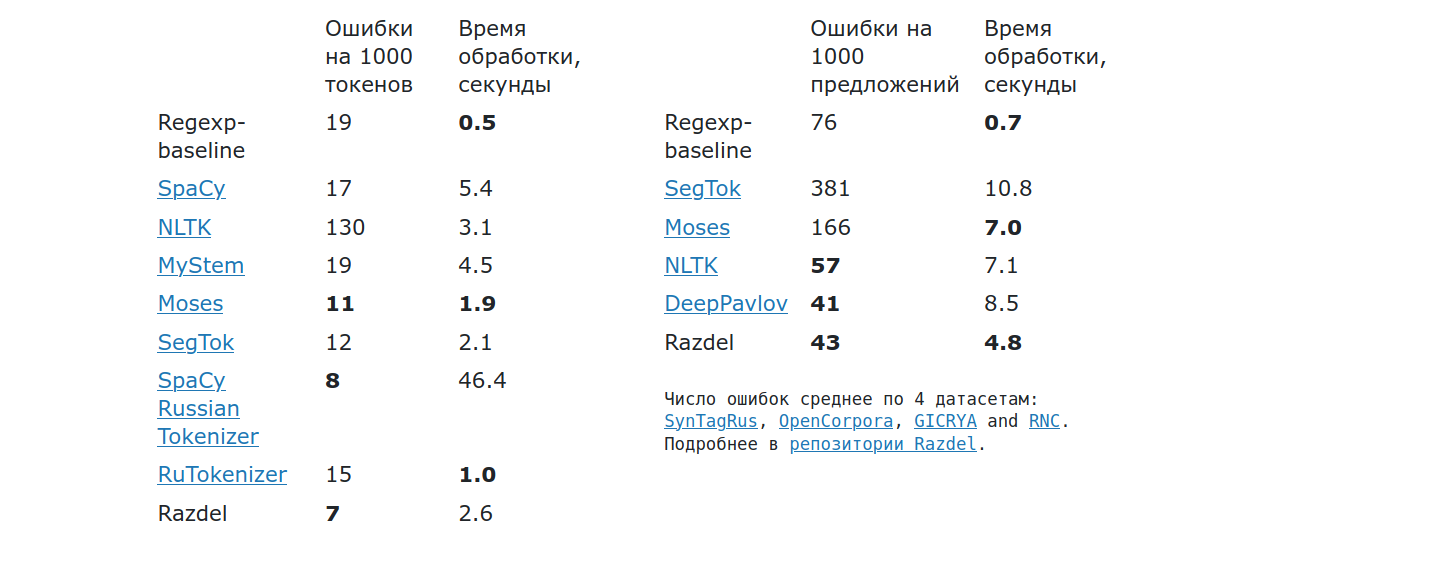

In [9]:
Stats = namedtuple("Stats", "vocabulary,lemma_vocabulary,words_counts,unique_words_counts")

def collect_stats(records, lower=True, text_max_words=3000, summary_max_words=100, nrows=1000):
    morph = pymorphy2.MorphAnalyzer()
    
    text_stats = Stats(Counter(),  Counter(), list(), list())
    summary_stats = Stats(Counter(),  Counter(), list(), list())

    def update_record_field_stats(field, stats, max_words):
        words = [word.text for word in razdel.tokenize(field)][:max_words]
        lemmas = [morph.parse(word)[0].normal_form for word in words]
        stats.vocabulary.update(words)
        stats.lemma_vocabulary.update(lemmas)
        stats.words_counts.append(len(words))
        stats.unique_words_counts.append(len(set(words)))

    for i, record in enumerate(records):
        if i >= nrows:
            break
        text = record["text"]
        text = text if not lower else text.lower()
        update_record_field_stats(text, text_stats, text_max_words)

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        summary_words = [word.text for word in razdel.tokenize(summary)]
        update_record_field_stats(summary, summary_stats, summary_max_words)
    return text_stats, summary_stats

In [10]:
train_text_stats, train_summary_stats = collect_stats(train_records)
print("Train texts vocabulary size: ", len(train_text_stats.vocabulary))
print("Train texts lemma vocabulary size: ", len(train_text_stats.lemma_vocabulary))
print("Train summaries vocabulary size: ", len(train_summary_stats.vocabulary))
print("Train summaries lemma vocabulary size: ", len(train_summary_stats.lemma_vocabulary))
print("Train common lemmas summary vs text: ", len(set(train_text_stats.lemma_vocabulary.keys()) & set(train_summary_stats.lemma_vocabulary.keys())))

Train texts vocabulary size:  82978
Train texts lemma vocabulary size:  37851
Train summaries vocabulary size:  15441
Train summaries lemma vocabulary size:  9030
Train common lemmas summary vs text:  8652


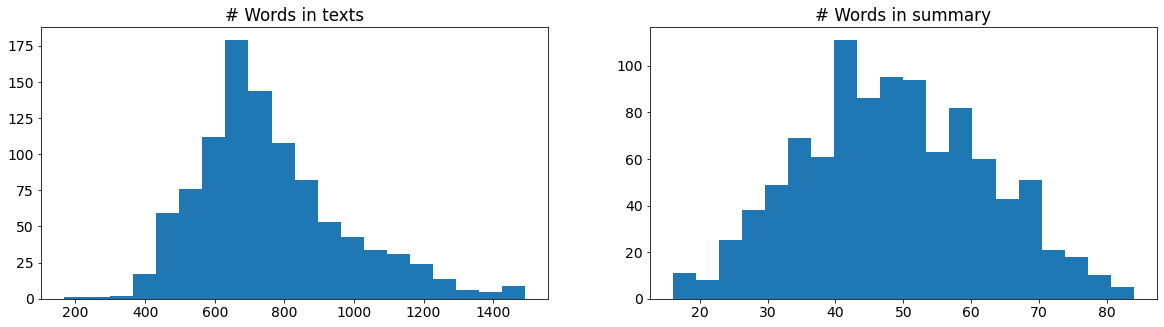

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].hist(train_text_stats.words_counts, 20)
axs[0].set_title('# Words in texts')

axs[1].hist(train_summary_stats.words_counts, 20)
axs[1].set_title('# Words in summary')
plt.show()

## Lead-3

Первый baseline - первые 3 предложения текста в качестве summary.


В качестве метрик здесь и далее используем BLEU и [ROUGE](https://).<br><br>

* **ROUGE-N** – measures unigram, bigram, trigram and higher order n-gram overlap
* **ROUGE-L** – measures longest matching sequence of words using LCS. An advantage of using LCS is thatit does not require consecutive matches but in-sequence matches that reflect sentence level wordorder. Since it automatically includes longest in-sequence common n-grams, you don’t need apredefined n-gram length.

In [12]:
def calc_scores(references, predictions, metric="all"):
    print("Count:", len(predictions))
    print("Ref:", references[-1])
    print("Hyp:", predictions[-1])

    if metric in ("bleu", "all"):
        print("BLEU: ", corpus_bleu([[r] for r in references], predictions))
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(predictions, references, avg=True)
        print("ROUGE: ", scores)

In [13]:
def calc_lead_n_score(records, n=3, lower=True, nrows=1000):
    references = []
    predictions = []

    for i, record in enumerate(records):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        text = text if not lower else text.lower()
        sentences = [sentence.text for sentence in razdel.sentenize(text)]
        prediction = " ".join(sentences[:n])
        predictions.append(prediction)

    calc_scores(references, predictions)

calc_lead_n_score(test_records, n=1)

Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: православный телеканал «спас», учредителем которого является московская патриархия, запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер в тверской области.
BLEU:  0.19177311186434495
ROUGE:  {'rouge-1': {'f': 0.23804097238957525, 'p': 0.22208274285774904, 'r': 0.37762764047433917}, 'rouge-2': {'f': 0.10027796832321115, 'p': 0.09647636782929753, 'r': 0.15833772153385062}, 'rouge-l': {'f': 0.1835646488408507, 'p': 0.2022959168891477, 'r': 0.34937017731940756}}


##TextRank

https://habr.com/ru/post/455762/

TextRank - unsupervised метод для составления кратких выжимок из текста. 
Описание метода:

1. Сплитим текст по предложениям
2. Считаем "похожесть" предложений между собой
3. Строим граф предложений с взвешенными ребрами
4. С помощью алгоритм PageRank получаем наиболее важные предложения, на основе которых делаем summary.

### Самописный TextRank

In [14]:
def unique_words_similarity(words1, words2):
    '''
    Функция подсчёта близости предложений на основе пересечения слов
    ''' 
    words1 = set(words1)
    words2 = set(words2)
    if not len(words1) or not len(words2):
        return 0.0
    return len(words1.intersection(words2)) / (len(words1) + len(words2))
    #return len(words1.intersection(words2)) / (np.log10(len(words1)) + np.log10(len(words2)))

def gen_text_rank_summary(text, calc_similarity=unique_words_similarity, summary_part=0.1, lower=True, morph=None):
    '''
    Составление summary с помощью TextRank
    '''
    # Разбиваем текст на предложения
    sentences = [sentence.text for sentence in razdel.sentenize(text)]
    n_sentences = len(sentences)

    # Токенизируем предложения
    sentences_words = [[token.text.lower() if lower else token.text for token in razdel.tokenize(sentence)] for sentence in sentences]

    # При необходимости лемматизируем слова
    if morph is not None:
        sentences_words = [[morph.parse(word)[0].normal_form for word in words] for words in sentences_words]

    # Для каждой пары предложений считаем близость
    pairs = combinations(range(n_sentences), 2)
    scores = [(i, j, calc_similarity(sentences_words[i], sentences_words[j])) for i, j in pairs]

    # Строим граф с рёбрами, равными близости между предложениями
    g = nx.Graph()
    g.add_weighted_edges_from(scores)

    # Считаем PageRank
    
    pr = nx.pagerank(g)
    result = [(i, pr[i], s) for i, s in enumerate(sentences) if i in pr]
    result.sort(key=lambda x: x[1], reverse=True)

    # Выбираем топ предложений
    n_summary_sentences = max(int(n_sentences * summary_part), 1)
    result = result[:n_summary_sentences]

    # Восстанавливаем оригинальный их порядок
    result.sort(key=lambda x: x[0])
    
    num_sents = len(result)
    # Восстанавливаем текст выжимки
    predicted_summary = " ".join([sentence for i, proba, sentence in result])
    predicted_summary = predicted_summary.lower() if lower else predicted_summary
    return predicted_summary, num_sents

def calc_text_rank_score(records, calc_similarity=unique_words_similarity, summary_part=0.1, lower=True, nrows=1000, morph=None):
    references = []
    predictions = []
    length_sents = [] 

    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        predicted_summary, num_sents = gen_text_rank_summary(text, calc_similarity, summary_part, lower, morph=morph)
        length_sents.append(num_sents)
        text = text if not lower else text.lower()
        predictions.append(predicted_summary)

    print(f'Mean number of sents in summary: {np.mean(length_sents)}')
    calc_scores(references, predictions)

morph = pymorphy2.MorphAnalyzer()
calc_text_rank_score(test_records)

Mean number of sents in summary: 3.276
Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: в комментарии также отмечается, что это беспрецедентный подобный проект на телевидении. съемки начнутся уже в ноябре», — указывается в анонсе. от «зенита» до «спартака», — сказал священник. в июне нынешнего года сообщалось, что рпц планирует сделать из сергиева посада «православный ватикан».
BLEU:  0.3508755059541153
ROUGE:  {'rouge-1': {'f': 0.15466400887322831, 'p': 0.16298929023222172, 'r': 0.15602281048791292}, 'rouge-2': {'f': 0.030615979709094604, 'p': 0.031077035455225686, 'r': 0.032019614611385826}, 'rouge-l': {'f': 0.13373567967669006, 'p': 0.14775573752428653, 'r': 0.1

Сделаем TextRank с другой мерой близости предложений: по FastText, ELMo или BERT эмбеддингам


<img src="https://raw.githubusercontent.com/natasha/natasha-logos/master/navec.svg">
<br>


[Navec](https://github.com/natasha/navec)

In [15]:
%%capture
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar

In [16]:
path = 'navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path) 

In [17]:
def vectorize_sum(words, embeddings):

    embedding_dim = embeddings['example'].shape[0]
    features = np.zeros([embedding_dim], dtype='float32')

    num_known_words = 0
    for word in words:
        if word in embeddings:
            num_known_words += 1
            features += embeddings[f'{word}']

    if num_known_words:
        return features / num_known_words
    else: return features

def my_sim(text1, text2, embeddings=navec, kind='cos'):

    v1, v2 = vectorize_sum(text1, embeddings), vectorize_sum(text2, embeddings)
    if np.sum(v1) == 0.0 or np.sum(v2) == 0.0:
        return 0 

    return np.abs(np.dot(v1, v2) / norm(v1) / norm(v2))

In [18]:
calc_text_rank_score(test_records, calc_similarity=my_sim, morph=morph)

Mean number of sents in summary: 3.276
Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: «у нас же даже многие журналисты не знают и не понимают многого, связанного с религиозными ценностями, а здесь — попытка обратить их внимание на это, может быть, им будет интересно. и это что — жизнь, что ли? «если человеку невоцерковленному, далекому от церкви, в двух словах сказать, для чего нужна церковь — церковь… нужна для того, чтобы был силен дух нашего народа», — говорил предстоятель. по словам патриарха, им станет тот, кто будет стоять «во главе всемирной паутины».
BLEU:  0.2736838350215274
ROUGE:  {'rouge-1': {'f': 0.15109432683062032, 'p': 0.12445104194115493, 'r': 0.

### Summa

In [19]:
def calc_summa_score(records, summary_part=0.1, lower=True, nrows=1000):
    references = []
    predictions = []

    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        text = text if not lower else text.lower()
        predicted_summary = summarize(text, ratio=summary_part, language='russian').replace("\n", " ")
        predictions.append(predicted_summary)

    calc_scores(references, predictions)

calc_summa_score(test_records)

Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: проживи месяц в ниловой пустыни, выполняя послушания, и найди ответы на вопросы, которые давно беспокоят», — так анонсирует телеканал свой проект. «у нас же даже многие журналисты не знают и не понимают многого, связанного с религиозными ценностями, а здесь — попытка обратить их внимание на это, может быть, им будет интересно. стоит отметить, что участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека. и это что — жизнь, что ли?
BLEU:  0.2762958192799957
ROUGE:  {'rouge-1': {'f': 0.1770425497877709, 'p': 0.14391909693539454, 'r': 0.247378763312854

## Oracle summary

Для сведения задачи к extractive summarization мы должны выбрать те предложения из оригинального текста, которые наиболее похожи на наше целевое summary по нашим метрикам.

In [20]:
def build_oracle_summary_greedy(text, gold_summary, calc_score, lower=True, max_sentences=30):
    '''
    Жадное построение oracle summary
    '''
    gold_summary = gold_summary.lower() if lower else gold_summary
    # Делим текст на предложения
    sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
    n_sentences = len(sentences)
    oracle_summary_sentences = set()
    
    score = -1.0
    summaries = []
    for _ in range(n_sentences):
        for i in range(n_sentences):
            if i in oracle_summary_sentences:
                continue
            current_summary_sentences = copy.copy(oracle_summary_sentences)
            # Добавляем какое-то предложения к уже существующему summary
            current_summary_sentences.add(i)
            current_summary = " ".join([sentences[index] for index in sorted(list(current_summary_sentences))])
            # Считаем метрики
            current_score = calc_score(current_summary, gold_summary)
            summaries.append((current_score, current_summary_sentences))
        # Если получилось улучшить метрики с добавлением какого-либо предложения, то пробуем добавить ещё
        # Иначе на этом заканчиваем
        best_summary_score, best_summary_sentences = max(summaries)
        if best_summary_score <= score:
            break
        oracle_summary_sentences = best_summary_sentences
        score = best_summary_score
    oracle_summary = " ".join([sentences[index] for index in sorted(list(oracle_summary_sentences))])
    return oracle_summary, oracle_summary_sentences

def calc_single_score(pred_summary, gold_summary, rouge):
    return rouge.get_scores([pred_summary], [gold_summary], avg=True)['rouge-2']['f']

In [21]:
def calc_oracle_score(records, nrows=1000, lower=True):
    references = []
    predictions = []
    rouge = Rouge()
  
    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        predicted_summary, _ = build_oracle_summary_greedy(text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge))
        predictions.append(predicted_summary)

    calc_scores(references, predictions)


calc_oracle_score(test_records)

Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: православный телеканал «спас», учредителем которого является московская патриархия, запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер в тверской области. в комментарии также отмечается, что это беспрецедентный подобный проект на телевидении. стоит отметить, что участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
BLEU:  0.531336150784986
ROUGE:  {'rouge-1': {'f': 0.36951810858804146, 'p': 0.4053281117404892, 'r': 0.3661389123393327}, 'rouge-2': {'f': 0.2087846693590

## Extractive RNN

Теперь пробуем предсказать oracle summary

### BPE
Для начала сделаем BPE токенизацию

In [22]:
def train_bpe(records, model_path, model_type="bpe", vocab_size=10000, lower=True):
    temp_file_name = "temp.txt"
    with open(temp_file_name, "w") as temp:
        for record in records:
            text, summary = record['text'], record['summary']
            if lower:
                summary = summary.lower()
                text = text.lower()
            if not text or not summary:
                continue
            temp.write(text + "\n")
            temp.write(summary + "\n")
    yttm.BPE.train(data=temp_file_name, vocab_size=vocab_size, model=model_path)

train_bpe(train_records, "BPE_model.bin")

In [23]:
bpe_processor = yttm.BPE('BPE_model.bin')
bpe_processor.encode('привет. это я, убегаю от тебя', output_type=yttm.OutputType.SUBWORD)

['▁привет', '.', '▁это', '▁я', ',', '▁убе', 'га', 'ю', '▁от', '▁тебя']

In [24]:
words = ['▁привет', '▁это', '▁я', ',', '▁убе', 'га', 'ю', '▁от', '▁тебя']

In [25]:
bpe_processor.decode([bpe_processor.subword_to_id(word) for word in words])

['привет это я, убегаю от тебя']

### Словарь
Составим словарь для индексации токенов

In [26]:
vocabulary = bpe_processor.vocab()

### Кэш oracle summary
Закэшируем oracle summary, чтобы не пересчитывать их каждый раз

In [27]:
def add_oracle_summary_to_records(records, max_sentences=30, lower=True, nrows=1000):
    rouge = Rouge()
    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break
        text = record["text"]
        summary = record["summary"]

        summary = summary.lower() if lower else summary
        sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
        oracle_summary, sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge),
                                                                         lower=lower, max_sentences=max_sentences)
        record["sentences"] = sentences
        record["oracle_sentences"] = list(sentences_indicies)
        record["oracle_summary"] = oracle_summary

    return records[:nrows]

ext_train_records = add_oracle_summary_to_records(train_records, nrows=2048)
ext_val_records = add_oracle_summary_to_records(val_records, nrows=256)
ext_test_records = add_oracle_summary_to_records(test_records, nrows=256)

### Составление батчей

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [29]:
class BatchIterator():
    def __init__(self, records, vocabulary, batch_size, bpe_processor, shuffle=True, lower=True, max_sentences=30, max_sentence_length=50, device=torch.device('cpu')):
        self.records = records
        self.num_samples = len(records)
        self.batch_size = batch_size
        self.bpe_processor = bpe_processor
        self.shuffle = shuffle
        self.batches_count = int(math.ceil(self.num_samples / batch_size))
        self.lower = lower
        self.rouge = Rouge()
        self.vocabulary = vocabulary
        self.max_sentences = max_sentences
        self.max_sentence_length = max_sentence_length
        self.device = device
        
    def __len__(self):
        return self.batches_count
    
    def __iter__(self):
        indices = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(indices)

        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)
            batch_indices = indices[start:end]

            batch_inputs = []
            batch_outputs = []
            max_sentence_length = 0
            max_sentences = 0
            batch_records = []

            for data_ind in batch_indices:
                
                record = self.records[data_ind]
                batch_records.append(record)
                text = record["text"]
                summary = record["summary"]
                summary = summary.lower() if self.lower else summary

                if "sentences" not in record:
                    sentences = [sentence.text.lower() if self.lower else sentence.text for sentence in razdel.sentenize(text)][:self.max_sentences]
                else:
                    sentences = record["sentences"]
                max_sentences = max(len(sentences), max_sentences)
                
                # номера предложений, которые в нашем саммари
                if "oracle_sentences" not in record:
                    calc_score = lambda x, y: calc_single_score(x, y, self.rouge)
                    sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=calc_score, lower=self.lower, max_sentences=self.max_sentences)[1]
                else:   
                    sentences_indicies = record["oracle_sentences"]
                
                # inputs - индексы слов в предложении
                inputs = [bpe_processor.encode(sentence)[:self.max_sentence_length] for sentence in sentences]
                max_sentence_length = max(max_sentence_length, max([len(tokens) for tokens in inputs]))
                
                # получение метки класса предложения
                outputs = [int(i in sentences_indicies) for i in range(len(sentences))]
                batch_inputs.append(inputs)
                batch_outputs.append(outputs)

            tensor_inputs = torch.zeros((self.batch_size, max_sentences, max_sentence_length), dtype=torch.long, device=self.device)
            # we add index 2 for padding 
            tensor_outputs = torch.zeros((self.batch_size, max_sentences), dtype=torch.float32, device=self.device) + 2

            for i, inputs in enumerate(batch_inputs):
                for j, sentence_tokens in enumerate(inputs):
                    tensor_inputs[i][j][:len(sentence_tokens)] = torch.tensor(sentence_tokens, dtype=torch.int64)

            for i, outputs in enumerate(batch_outputs):
                tensor_outputs[i][:len(outputs)] = torch.LongTensor(outputs)

            tensor_outputs = tensor_outputs.long()
            yield {
                'inputs': tensor_inputs,
                'outputs': tensor_outputs,
                'records': batch_records
            }

In [30]:
train_iterator = BatchIterator(ext_train_records, vocabulary, 32, bpe_processor, device=device)
val_iterator = BatchIterator(ext_val_records, vocabulary, 32, bpe_processor, device=device)
test_iterator = BatchIterator(ext_test_records, vocabulary, 32, bpe_processor, device=device)

## Extractor -  SummaRuNNer
 [SummaRuNNer: A Recurrent Neural Network based Sequence Model for
Extractive Summarization of Documents](https://arxiv.org/pdf/1611.04230.pdf)


### Homework

* В данной реализации в `outputs` в качестве padding используется индекс 0. Измените в функции \_\_iter__ индекс padding, чтобы он не совпадал с классом 0 или 1, например, 2.
* В качестве criterion используйте `CrossEntropyLoss`вместо `BCEWithLogitsLoss`
* Из-за смены criterion, вы уже должны подавать на вход criterion ни одно число, а logits для каждого класса. Перед подачей logits вы можете отфильтровать предсказания для класса padding. В этом пункте вам придется изменять файл `train_model.py`, а именно функциии `train` и `evaluate`.
* Используйте два варианта обучения: c весами в `CrossEntropyLoss` и без
* Также сравните `inference`, когда вы ранжируете logits, и когды вы выбирате предложения, у котрых logits > 0, в двух вариантах обучения. 
* Реализуйте дополнительно характеристику предложения `novelty`. Как влияет добавление `novelty` на качество summary?
* Постарайтесь улучшить качество модели, полученной на семинаре: $BLEU \approx 0.45$

## Model
$P\left(y_{j} = 1 \mid \mathbf{h}_{j}, \mathbf{s}_{j}, \mathbf{d}\right)=\sigma\left(W_{c} \mathbf{h}_{j} + \mathbf{h}_{j}^{T} W_{s} \mathbf{d}\right)$
--------------------

In [31]:
PAD_IDX = 2

In [41]:
class SentenceEncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, n_layers=3, dropout=0.3, bidirectional=True):
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.embedding_dim = embedding_dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.embedding_layer = nn.Embedding(input_size, embedding_dim)
        self.rnn_layer = nn.LSTM(embedding_dim, hidden_size, n_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, inputs, hidden=None):
        embedded = self.dropout_layer(self.embedding_layer(inputs))
        outputs, _ = self.rnn_layer(embedded, hidden)
        sentences_embeddings = torch.mean(outputs, 1)
        # [batch_size, hidden_size]
        return sentences_embeddings

class SentenceTaggerRNN(nn.Module):
    def __init__(self,
                 vocabulary_size,
                 use_content=True,
                 use_salience=True,
                 use_novelty=True,
                 token_embedding_dim=128,
                 sentence_encoder_hidden_size=256,
                 hidden_size=256,
                 bidirectional=True,
                 sentence_encoder_n_layers=2,
                 sentence_encoder_dropout=0.3,
                 sentence_encoder_bidirectional=True,
                 n_layers=2,
                 dropout=0.3):
        
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.sentence_encoder = SentenceEncoderRNN(vocabulary_size, token_embedding_dim,
                                                   sentence_encoder_hidden_size, sentence_encoder_n_layers, 
                                                   sentence_encoder_dropout, sentence_encoder_bidirectional)
        
        self.rnn_layer = nn.LSTM(sentence_encoder_hidden_size, hidden_size, n_layers, dropout=dropout,
                           bidirectional=bidirectional, batch_first=True)
        
        self.dropout_layer = nn.Dropout(dropout)
        self.content_linear_layer = nn.Linear(hidden_size * 2, 1)
        self.document_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.salience_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.novelty_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.tanh_layer = nn.Tanh()

        self.use_content = use_content
        self.use_salience = use_salience
        self.use_novelty = use_novelty

    def forward(self, inputs, hidden=None):
        # parameters of the probability
        content = 0
        salience = 0
        novelty = 0

        # [batch_size, seq num, seq_len]
        batch_size = inputs.size(0)
        sentences_count = inputs.size(1)
        tokens_count = inputs.size(2)
        inputs = inputs.reshape(-1, tokens_count)
        # [batch_size * seq num, seq_len]

        embedded_sentences = self.sentence_encoder(inputs)
        embedded_sentences = self.dropout_layer(embedded_sentences.reshape(batch_size, sentences_count, -1))
        # [batch_size *  seq num, seq_len, hidden_size] -> [batch_size, seq num, hidden_size]

        outputs, _ = self.rnn_layer(embedded_sentences, hidden)
        # [batch_size, seq num, hidden_size]

        document_embedding = self.tanh_layer(self.document_linear_layer(torch.mean(outputs, 1)))
        # [batch_size, hidden_size]

        # W * h^T
        if self.use_content:
            content = self.content_linear_layer(outputs).squeeze(2) # 1-representation
        # [batch_size, seq num]

        # h^T * W * d
        if self.use_salience:
            salience = torch.bmm(outputs, self.salience_linear_layer(document_embedding).unsqueeze(2)).squeeze(2) # 2-representation
        # [batch_size, seq num, hidden_size] * [batch_size, hidden_size, 1] = [batch_size, seq num, ]

        

        if self.use_novelty:
            # at every step add novelty to prediction of the sentence
            predictions = content + salience
            
            # 0) initialize summary_representation and novelty by zeros
            # YOUR CODE
            """
            paper implementation:
            https://github.com/kedz/nnsum/blob/master/nnsum/module/sentence_extractor/summarunner_sentence_extractor.py
            """
            
            novelty = torch.zeros((batch_size, sentences_count)).to(device)
            summary_representation = torch.zeros((batch_size, self.hidden_size*2)).to(device)

            for sentence_num in range(sentences_count):
                # YOUR CODE
                
                # 1) take sentence_num_state from outputs(representation of the sentence with number sentence_num)
                sentence_num_state = outputs[:, sentence_num, :]
                # [seq num, hidden_size]
                
                # 2) calculate novelty for current sentence
                novelty[:, sentence_num] = -torch.bmm(sentence_num_state.unsqueeze(1),
                                                      self.novelty_linear_layer(torch.tanh(summary_representation)).unsqueeze(2)).squeeze(2).squeeze(1)
                # [seq num]                                                      
                
                # 3) add novelty to predictions
                predictions[:, sentence_num] += novelty[:, sentence_num] 
                
                # 4) calculcate probability for current sentence
                probabilities = torch.sigmoid(predictions[:, sentence_num])
                
                # 5) add sentence_num_state with the weight which is equal to probability to summary_representation
                summary_representation += torch.mv(sentence_num_state.transpose(0, 1), probabilities)
            
            return predictions
        
        
        return content + salience

In [33]:
vocab_size = len(vocabulary)
model = SentenceTaggerRNN(vocab_size).to(device)

In [34]:
params_count = np.sum([p.numel() for p in model.parameters() if p.requires_grad])
print("Trainable params: {}".format(params_count))

Trainable params: 2927617


Trainable params: 2927617

In [35]:
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")

sentence_encoder.embedding_layer.weight: 1280000
sentence_encoder.rnn_layer.weight_ih_l0: 65536
sentence_encoder.rnn_layer.weight_hh_l0: 65536
sentence_encoder.rnn_layer.bias_ih_l0: 512
sentence_encoder.rnn_layer.bias_hh_l0: 512
sentence_encoder.rnn_layer.weight_ih_l0_reverse: 65536
sentence_encoder.rnn_layer.weight_hh_l0_reverse: 65536
sentence_encoder.rnn_layer.bias_ih_l0_reverse: 512
sentence_encoder.rnn_layer.bias_hh_l0_reverse: 512
sentence_encoder.rnn_layer.weight_ih_l1: 131072
sentence_encoder.rnn_layer.weight_hh_l1: 65536
sentence_encoder.rnn_layer.bias_ih_l1: 512
sentence_encoder.rnn_layer.bias_hh_l1: 512
sentence_encoder.rnn_layer.weight_ih_l1_reverse: 131072
sentence_encoder.rnn_layer.weight_hh_l1_reverse: 65536
sentence_encoder.rnn_layer.bias_ih_l1_reverse: 512
sentence_encoder.rnn_layer.bias_hh_l1_reverse: 512
rnn_layer.weight_ih_l0: 131072
rnn_layer.weight_hh_l0: 65536
rnn_layer.bias_ih_l0: 512
rnn_layer.bias_hh_l0: 512
rnn_layer.weight_ih_l0_reverse: 131072
rnn_layer.wei

In [36]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        # YOUR CODE
        model.train()
        logits = model(batch["inputs"])
        target = batch["outputs"]
        prob = torch.sigmoid(logits)
        input = torch.cat([(1-prob).unsqueeze(-1), prob.unsqueeze(-1)], dim=2)
        input = input.view(-1,2)
        target = target.view(-1,1)[:,0]
        loss = criterion(input, target)

        # mask = (batch["outputs"]!=2).long()
        # logits = model(batch["inputs"])
        # loss = criterion(logits[mask].float(), batch["outputs"][mask].float())

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        history.append(loss.item())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

@torch.no_grad()
def evaluate(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):

        # YOUR CODE
        model.eval()
        logits = model(batch["inputs"])
        target = batch["outputs"]
        prob = torch.sigmoid(logits)
        input = torch.cat([(1-prob).unsqueeze(-1), prob.unsqueeze(-1)], dim=2)
        input = input.view(-1,2)
        target = target.view(-1,1)[:,0]
        loss = criterion(input, target)
        
        # mask = (batch["outputs"]!=2).long()
        # logits = model(batch["inputs"])
        # loss = criterion(logits[mask].float(), batch["outputs"][mask].float())
        
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


def train_with_logs(model, train_iterator, valid_iterator, optimizer, criterion, N_EPOCHS, CLIP):
    train_history = []
    valid_history = []
    
    
    best_valid_loss = float('inf')
    
    for epoch in range(N_EPOCHS):
        
        start_time = time.time()
        
        train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
        valid_loss = evaluate(model, valid_iterator, criterion)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best-val-model.pt')
        
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        
def punct_detokenize(text):
    text = text.strip()
    punctuation = ",.!?:;%"
    closing_punctuation = ")]}"
    opening_punctuation = "([}"
    for ch in punctuation + closing_punctuation:
        text = text.replace(" " + ch, ch)
    for ch in opening_punctuation:
        text = text.replace(ch + " ", ch)
    res = [r'"\s[^"]+\s"', r"'\s[^']+\s'"]
    for r in res:
        for f in re.findall(r, text, re.U):
            text = text.replace(f, f[0] + f[2:-2] + f[-1])
    text = text.replace("' s", "'s").replace(" 's", "'s")
    text = text.strip()
    return text


def postprocess(ref, hyp, is_multiple_ref=False, detokenize_after=False, tokenize_after=True):
    if is_multiple_ref:
        reference_sents = ref.split(" s_s ")
        decoded_sents = hyp.split("s_s")
        hyp = [w.replace("<", "&lt;").replace(">", "&gt;").strip() for w in decoded_sents]
        ref = [w.replace("<", "&lt;").replace(">", "&gt;").strip() for w in reference_sents]
        hyp = " ".join(hyp)
        ref = " ".join(ref)
    ref = ref.strip()
    hyp = hyp.strip()
    if detokenize_after:
        hyp = punct_detokenize(hyp)
        ref = punct_detokenize(ref)
    if tokenize_after:
        hyp = hyp.replace("@@UNKNOWN@@", "<unk>")
        hyp = " ".join([token.text for token in razdel.tokenize(hyp)])
        ref = " ".join([token.text for token in razdel.tokenize(ref)])
    return ref, hyp

In [37]:
# %%capture
# !gdown https://drive.google.com/uc?id=1MiS_iczALcyF7zGDPY6niyeD82P0_PBH -O train_model.py

In [38]:
# import train_model
# import imp 
# imp.reload(train_model)
# from train_model import train_with_logs
# from train_model import punct_detokenize, postprocess

def inference_summarunner(model, iterator, top_k=3):

    references = []
    predictions = []

    model.eval()
    for batch in test_iterator:

        logits = model(batch['inputs'])
        sum_in = torch.argsort(logits, dim=1)[:, -top_k:]
        
        for i in range(len(batch['outputs'])):

            summary = batch['records'][i]['summary'].lower()
            preds = [batch['records'][i]['sentences'][ind] for ind in sum_in.sort(dim=1)[0][i] if ind < len(batch['records'][i]['sentences'])]
            if len(preds) == 0: continue
            pred_summary = ' '.join(preds)

            summary, pred_summary = postprocess(summary, pred_summary)

            references.append(summary)
            predictions.append(pred_summary)

    calc_scores(references, predictions)

In [39]:
def inference_summarunner_pos_logits(model, iterator):

    references = []
    predictions = []

    model.eval()
    for batch in test_iterator:

        logits = model(batch['inputs'])
        preds = F.relu(logits)
        sum_in = torch.nonzero(preds)
        if len(sum_in)==0: continue
        
        for i in range(len(batch['outputs'])):
     
            summary = batch['records'][i]['summary'].lower()
            preds = [batch['records'][i]['sentences'][ind] for ind in sum_in.sort(dim=1)[0][i] if ind < len(batch['records'][i]['sentences'])]
            if len(preds) == 0: continue
            pred_summary = ' '.join(preds)

            summary, pred_summary = postprocess(summary, pred_summary)

            references.append(summary)
            predictions.append(pred_summary)

    calc_scores(references, predictions)

In [71]:
vocab_size = len(vocabulary)
model = SentenceTaggerRNN(vocab_size, use_novelty=False).to(device)
inference_summarunner(model, test_iterator, 3)

Count: 222
Ref: российские фрегаты « адмирал макаров » и « адмирал григорович » с крылатыми ракетами « калибр-нк » проходят через турецкие проливы босфор и дарданеллы в направлении средиземного моря . ранее эти корабли уже участвовали в военной операции рф в сирии и теперь направляются туда на фоне обострившейся ситуации в идлибе .
Hyp: « сторонники ( президента сирии — « газета . ru » ) башара асада обязательно должны отступить за линию соприкосновения , определенную сочинскими договоренностями . время , отведенное асаду , истекает » , — напомнил турецкий лидер . до этого эрдоган требовал от сил асада отойти за линию идлибской зоны деэскалации .
BLEU:  0.32541180220677207
ROUGE:  {'rouge-1': {'f': 0.14907941718692483, 'p': 0.15575973671750123, 'r': 0.15503593522594167}, 'rouge-2': {'f': 0.02085323044433369, 'p': 0.02129276031772421, 'r': 0.02287847972304013}, 'rouge-l': {'f': 0.12268727686990814, 'p': 0.1362951444044977, 'r': 0.13504053549469144}}


рандомные веса 0.32

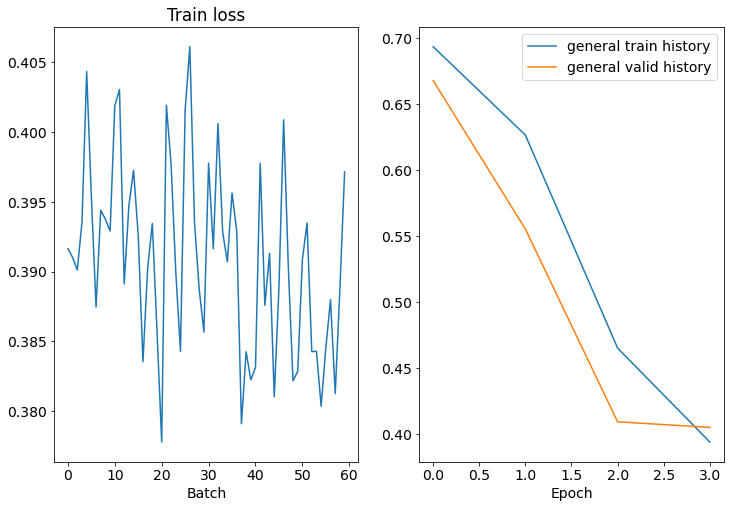

Epoch: 05 | Time: 0m 8s
	Train Loss: 0.391 | Train PPL:   1.479
	 Val. Loss: 0.405 |  Val. PPL:   1.499


In [43]:
vocab_size = len(vocabulary)
model = SentenceTaggerRNN(vocab_size, use_novelty=False).to(device)


N_EPOCHS = 5
CLIP = 1
lr=1e-5
optimizer = optim.Adam(model.parameters(), lr)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
train_with_logs(model, train_iterator, val_iterator, optimizer, criterion, N_EPOCHS, CLIP)

In [44]:
model.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model, test_iterator, 3)

Count: 256
Ref: зарубежные спецслужбы намеренно ищут уязвимости в российском it-секторе , чтобы проводить масштабные кибератаки , заявил секретарь совбеза николай патрушев . по его словам , основные цели злоумышленников – объекты критической информационной инфраструктуры рф . эти атаки — за год несколько миллионов случаев — создают угрозу национальной безопасности .
Hyp: иностранные спецслужбы проводят целенаправленный поиск уязвимостей российского it-сектора , чтобы массированно его атаковать . « активизировалась деструктивная деятельность иностранных спецслужб с целью дестабилизации общественно-политической обстановки в россии . украинские власти открыто заявляют об организации диверсионно-подрывной работы » , — добавил секретарь сб . патрушев пояснил , что опасность также представляют деятельность радикальных националистических и религиозных группировок , экстремистские проявления в интернете , рост ксенофобских настроений среди молодого поколения .
BLEU:  0.42063872770100186
ROUGE:

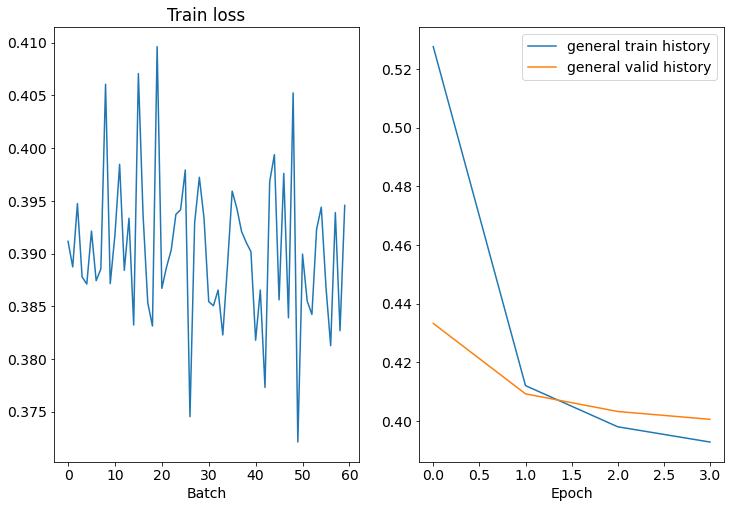

Epoch: 05 | Time: 0m 9s
	Train Loss: 0.390 | Train PPL:   1.477
	 Val. Loss: 0.399 |  Val. PPL:   1.490


In [45]:
vocab_size = len(vocabulary)
model = SentenceTaggerRNN(vocab_size).to(device)


N_EPOCHS = 5
CLIP = 1
lr=1e-5
optimizer = optim.Adam(model.parameters(), lr)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
train_with_logs(model, train_iterator, val_iterator, optimizer, criterion, N_EPOCHS, CLIP)

In [46]:
model.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model, test_iterator, 3)

Count: 256
Ref: украина будет компенсировать часть расходов иностранным компаниям при производстве фильмов на территории страны . по словам главы государства владимира зеленского , это сделает отрасль привлекательной для зарубежных инвестиций .
Hyp: верховная рада украины приняла во втором чтении поправки , которые предусматривают возмещение части расходов иностранным компаниям при производстве фильмов на территории страны , передает « укринформ » . « о внесении изменений в закон украины « о государственной поддержке кинематографии в украине » относительно государственной субсидии для возврата части квалифицированных расходов , осуществленных иностранным субъектом кинематографии при производстве ( создании ) фильма в украине » , — говорится в тексте документа . среди других известных зарубежных картин , некоторые сцены которых были сняты в украинской столице , — « прощальное дело » кристиана кариона с эмиром кустурицей в главной роли , « душка » голландского режиссера йоса стеллинга , 

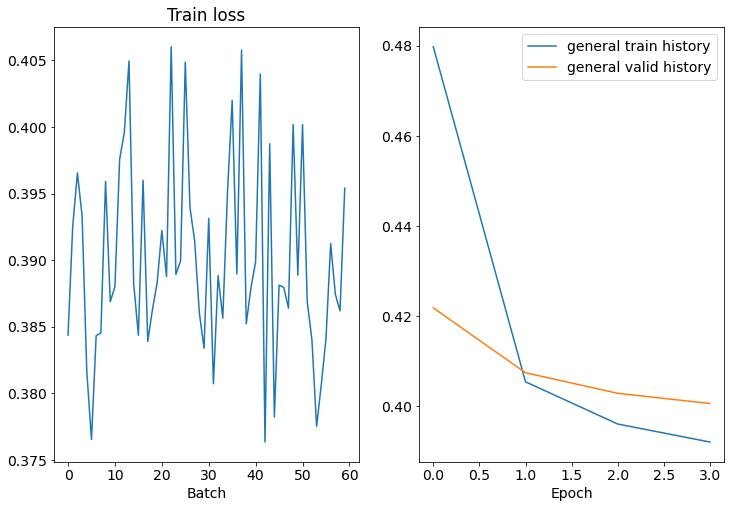

Epoch: 05 | Time: 0m 9s
	Train Loss: 0.390 | Train PPL:   1.477
	 Val. Loss: 0.399 |  Val. PPL:   1.491


In [47]:
vocab_size = len(vocabulary)
model = SentenceTaggerRNN(vocab_size, dropout=0.1).to(device)


N_EPOCHS = 5
CLIP = 1
lr=1e-5
optimizer = optim.Adam(model.parameters(), lr)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
train_with_logs(model, train_iterator, val_iterator, optimizer, criterion, N_EPOCHS, CLIP)

In [48]:
model.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model, test_iterator, 3)

Count: 256
Ref: в сети распространился новый способ хакерской атаки , заставляющей пользователей открыть зараженный файл — злоумышленник предлагает юзеру посмотреть на интимные фотографии девушки его друга , который якобы отказался платить за них выкуп и поплатился массовой рассылкой компрометирующих снимков всем своим контактам . как только жертва открывает прикрепленный файл , на ее компьютер загружается вредоносная программа .
Hyp: киберпреступники придумали новый способ заставить пользователя открыть вредоносный файл , прикрепленный к электронному письму , сообщает « би-би-си » . для этого используются несуществующие интимные фотографии девушки друга жертвы . многим юзерам известна хакерская атака , когда на почту приходит письмо с угрозами распространить компрометирующие фото или видео получателя , оказавшиеся в руках злоумышленника , который требует от жертвы выкуп в биткоинах .
BLEU:  0.42896805530804694
ROUGE:  {'rouge-1': {'f': 0.2991823904329159, 'p': 0.28059615200503524, 'r'

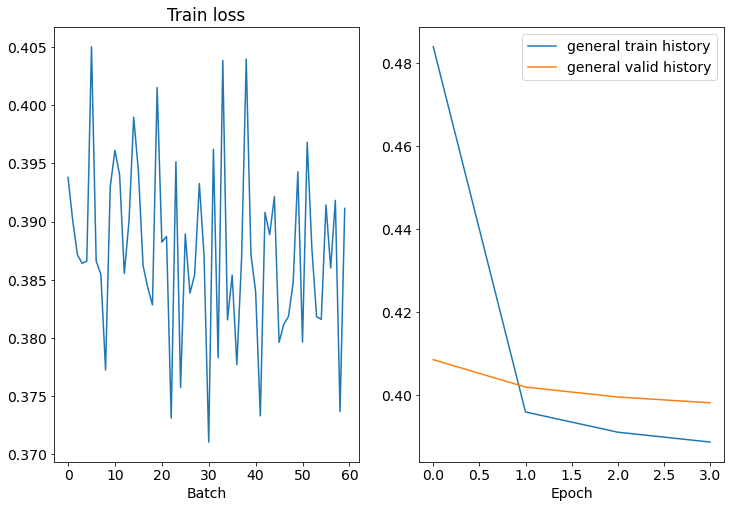

Epoch: 05 | Time: 0m 9s
	Train Loss: 0.387 | Train PPL:   1.473
	 Val. Loss: 0.397 |  Val. PPL:   1.488


In [49]:
vocab_size = len(vocabulary)
model = SentenceTaggerRNN(vocab_size, dropout=0.4, hidden_size=512).to(device)


N_EPOCHS = 5
CLIP = 1
lr=1e-5
optimizer = optim.Adam(model.parameters(), lr)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
train_with_logs(model, train_iterator, val_iterator, optimizer, criterion, N_EPOCHS, CLIP)

In [50]:
model.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model, test_iterator, 3)

Count: 256
Ref: бывшему президенту киргизии алмазбеку атамбаеву предъявлено уведомление о подозрении в убийстве начальника службы спецназа во время штурма дома экс-лидера . следствие утверждает , что оперативник был застрелен из снайперской винтовки , оформленной на атамбаева . политик является фигурантом еще 14 уголовных дел . в следующем году в киргизии пройдут парламентские выборы , на которых экс-президент представляет угрозу своему преемнику , даже находясь под арестом .
Hyp: экс-президент киргизии алмазбек атамбаев обвиняется в убийстве начальника службы спецназа . об этом сообщил глава мвд государства кашкар джунушалиев . телеканал прекратил вещание 7 августа , во время первой попытки штурма резиденции атамбаева и , тем не менее , продолжил вести прямую трансляцию операции в соцсетях .
BLEU:  0.42948311840566084
ROUGE:  {'rouge-1': {'f': 0.29940371033692625, 'p': 0.2807463521250686, 'r': 0.3402462362585514}, 'rouge-2': {'f': 0.13116412933993885, 'p': 0.12129836065761175, 'r': 0.

In [51]:
target = np.fromiter((v for batch in train_iterator for v in batch["outputs"].detach().cpu().numpy().flatten()), dtype=np.int)
target = target[target!=PAD_IDX]
class_weight = torch.tensor(compute_class_weight(class_weight='balanced',
                                    classes=np.unique(target),
                                    y=target), dtype=torch.float).to(device)

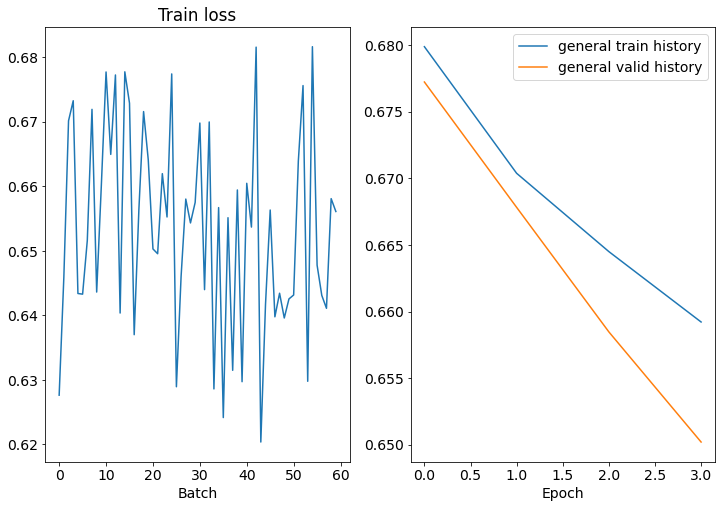

Epoch: 05 | Time: 0m 9s
	Train Loss: 0.653 | Train PPL:   1.922
	 Val. Loss: 0.640 |  Val. PPL:   1.897


In [52]:
vocab_size = len(vocabulary)
model = SentenceTaggerRNN(vocab_size).to(device)

N_EPOCHS = 5
CLIP = 1
lr=1e-5
optimizer = optim.Adam(model.parameters(), lr)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX, weight=class_weight)
train_with_logs(model, train_iterator, val_iterator, optimizer, criterion, N_EPOCHS, CLIP)

In [53]:
model.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model, test_iterator, 3)

Count: 256
Ref: в городе в течение 10 лет планируют в несколько раз увеличить количество резидентов из числа научных организаций и инженерных компаний , ориентированных на технологические проекты в сфере энергетики .
Hyp: к такому выводу на прошлой неделе пришли участники 12-го петербургского международного инновационного форума . директор фонда « центр стратегических разработок « северо-запад » марина липецкая отметила , что в петербурге сконцентрирован большой , даже с точки зрения мирового рынка , спрос на технологии и продукцию для нефтегазового и энергетического секторов . совместные действия власти и бизнеса должны привести к росту в городе научного знания и технологических разработок для этих направлений , как это произошло в свое время в американском хьюстоне .
BLEU:  0.3938310726729089
ROUGE:  {'rouge-1': {'f': 0.23881565200456506, 'p': 0.23509824331354653, 'r': 0.2600011251727167}, 'rouge-2': {'f': 0.07656905442484555, 'p': 0.07410567710530828, 'r': 0.08596341136994987}, 'rou

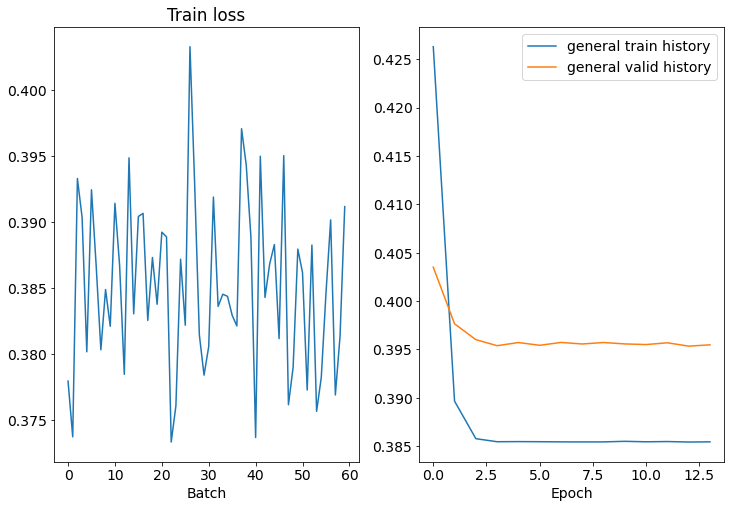

Epoch: 15 | Time: 0m 11s
	Train Loss: 0.385 | Train PPL:   1.470
	 Val. Loss: 0.395 |  Val. PPL:   1.485


In [76]:
vocab_size = len(vocabulary)
model = SentenceTaggerRNN(vocab_size, 
                          n_layers=6, 
                          dropout=0.4, 
                          sentence_encoder_dropout=0.3, 
                          sentence_encoder_hidden_size=256, 
                          token_embedding_dim=256,
                          use_content=True,
                          use_novelty=True,
                          use_salience=True).to(device)

N_EPOCHS = 15
CLIP = 1
lr=3e-5
optimizer = optim.Adam(model.parameters(), lr)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
train_with_logs(model, train_iterator, val_iterator, optimizer, criterion, N_EPOCHS, CLIP)

In [77]:
model.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model, test_iterator, 3)

Count: 256
Ref: в ростове-на-дону в квартире в центре города сотрудник следственного комитета взял в заложники беременную супругу . он угрожал ей травматическим пистолетом и удерживал взаперти на протяжении нескольких часов . в ск инцидент назвали « бытовым конфликтом » . мать силовика подтвердила эту версию — по ее словам , причиной произошедшего стал нервный срыв на почве ссоры .
Hyp: в одной из квартир в центре ростова-на-дону 38-летний сотрудник местного следственного комитета взял в заложники беременную жену . об этом сообщили в управлении ск по региону . по данным ведомства , инцидент произошел 20 ноября . жену он освободил добровольно » , — пишет telegram-канал . ткачева отправили на медосвидетельствование .
BLEU:  0.3349292029169457
ROUGE:  {'rouge-1': {'f': 0.28424791061041205, 'p': 0.22867677078420537, 'r': 0.39786373703348066}, 'rouge-2': {'f': 0.11816622207125291, 'p': 0.09217849875655634, 'r': 0.1765441145425508}, 'rouge-l': {'f': 0.2247620472120023, 'p': 0.206441991566372

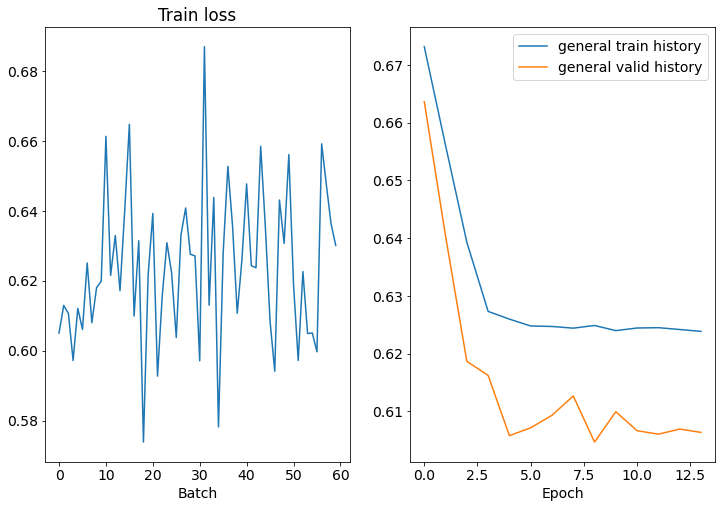

Epoch: 15 | Time: 0m 11s
	Train Loss: 0.624 | Train PPL:   1.867
	 Val. Loss: 0.606 |  Val. PPL:   1.832


In [74]:
vocab_size = len(vocabulary)
model = SentenceTaggerRNN(vocab_size, 
                          n_layers=6, 
                          dropout=0.4, 
                          sentence_encoder_dropout=0.3, 
                          sentence_encoder_hidden_size=256, 
                          token_embedding_dim=256,
                          use_content=True,
                          use_novelty=True,
                          use_salience=True).to(device)

N_EPOCHS = 15
CLIP = 1
lr=3e-5
optimizer = optim.Adam(model.parameters(), lr)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX, weight=class_weight)
train_with_logs(model, train_iterator, val_iterator, optimizer, criterion, N_EPOCHS, CLIP)

In [75]:
model.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model, test_iterator, 3)

Count: 256
Ref: сериал « макмафия » , рассказывающий историю сына бывшего босса русской мафии , стал лауреатом международной премии академии телевизионных наук и искусств « эмми » в номинации « лучшее драматическое шоу » . роли в проекте среди прочих исполнили российские актеры алексей серебряков и мария шукшина .
Hyp: британо-американский сериал « макмафия » , роли в котором исполнили российские актеры алексей серебряков и мария шукшина , стал лауреатом международной премии академии телевизионных наук и искусств « эмми » ( international emmy awards ) в номинации « лучшее драматическое шоу » . церемония вручения наград прошла 25 ноября в нью-йорке . « макмафия » , режиссирует которую джеймс уоткинс ( « черное зеркало » ) , рассказывает историю алекса годмана ( джеймс нортон ) , выросшего в великобритании сына бывшего босса русской мафии , который отчаянно пытается отойти от своего прошлого ( но это не особо получается ) .
BLEU:  0.4613358093852308
ROUGE:  {'rouge-1': {'f': 0.3173318124

## Вывод:

модель на рандомных весах без тренировки - BLEU:  0.32541180220677207

без novelty - BLEU ~ 0.42

с novelty - BLEU ~ 0.44

добавление весов по классам не добавило перфоманса (BLEU ~ 0.39) для дефолтных настроек, но если увеличивать размер эмбеддингов и размер hidden size, BLEU ~ 0.45

но вообще замечено, что довольно быстро сетка уходит в минимум на 3 эпохе и потом не обучается, попытка уменьшить lr не дала видимого успеха (хотя можно было добавить cycle lr sheduler) 

удалось добиться BLEU 0.46 (хотя думаю можно улучшить) за счет поиска гиперпараметров, увеличив количество слоев до 6 